# Autoencoder Neural Networks

## Introduction

The autoencoder neural network is an unsupervised type of artificial neural network that learns to represent the data in a lower-dimensional space by encoding the data and then reconstructing the data back from the reduced space representation of the data. The autoencoder is trained to get an output as close as possible to its input. 

The autoencoder neural consists of three main parts:

1. **Encoder**: The data input dimensions are reduced and then encoded into a lower-dimensional representation.
2. **Bottleneck**: It is the layer where it contains the lowest dimensional representation of the input data in the neural network.
3. **Decoder**: The original data is reconstructed from the encoded representation.

A simple schema of an autoencoder neural network where its input is an image is presented below:

<figure>
  <img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg">
  <figcaption>Fig.1 - Autoencoder [<a href="https://blog.keras.io/building-autoencoders-in-keras.html">Keras</a>].</figcaption>
</figure> 

The encoder and the decoder parts of the autoencoder neural network could be simply visualised as an encoder function $\textbf{h} = f(\textbf{x})$ and as a decoder function $\textbf{x} = g(\textbf{h})$. Thus, an autoencoder could simply be represented as $g(f(\textbf{x})) = \textbf{x}$. However, according to [Goodfellow et al. 2016](https://www.deeplearningbook.org/contents/autoencoders.html), the autoencoder neural networks have an generalised idea of an encoder and a decoder, where the encoder and decoder can be viewed as a stochastic mappings $p_{encoder}(\textbf{h}|\textbf{x})$ and $p_{decoder}(\textbf{x}|\textbf{h})$. Because the autoencoders are unable to learn to copy perfectly and they are restricted in ways that allows only to approximately copy the input data. The model during the training process is forced to determine which aspects of the input should be learned, and often useful properties of the
data are learned.

Traditionally, the autoencoders have been used for dimensionality reduction and feature learning. However, within the development of the generative modelling theoretical connections between autoencoders and latent variable models were found and brought the autoencoder as a competitive model of generative modelling.

### Architectures

The autoencoder neural network architecture is quite diverse. If it is possible to sequentially reduce and then expand the dimensions back to the original dimension, it is possible to obtain an autoencoder neural network. Therefore, some autoencoders use fully-connected, convolutional, LSTM, or a combination of then. The usage of each layer type depends on the problem that being tried to address.

A different architecture that received quite atention recently are the architectures based on the Variational Autoencoder (VAE). These architectures are generative models and as mentioned by [Goodfellow et al. 2016](https://www.deeplearningbook.org/contents/autoencoders.html), they have a theoretical connections with latent variable models such as Generative Adversarial Networks (GAN).

### Applications

The autoencoders have a wide variety of applications such as dimensionality reduction [[Wang, et al. 2014](https://www.cv-foundation.org/openaccess/content_cvpr_workshops_2014/W15/papers/Wang_Generalized_Autoencoder_A_2014_CVPR_paper.pdf)], feature learning, anomaly detection [[Sakurada and Yairi 2014](https://dl.acm.org/doi/pdf/10.1145/2689746.2689747)], data denoising [[Vincent, et al. 2010](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)].

Another application for the autoencoder is for generative modelling, where, for instance, images are generated by sampling data from reduced lower dimension space.

## Development

It is quite known in the neural network development the necessity to perform a hyperparameter optimisation. However, the training process of a single neural network can take hours depending on the architecture and the amount of data being trained. Therefore, this notebook will quickly assess different autoencoder neural network architectures with similar sizes to select the most promising architectures to perform a hyperparameter optimisation.

For the sake of simplicity, it was created a Jupyter notebook for each architecture, where the training process can be followed. In this notebook the architectures will be loaded and the results will be compared.

The architectures evaluated were: 
1. [Convolutional autoencoder](./tests/jupyter-notebooks/train_ae_conv.ipynb);
1. [Convolutional autoencoder with dropout](./tests/jupyter-notebooks/train_ae_conv_drop.ipynb);
1. [VQ-VAE-2 based autoencoder](./tests/jupyter-notebooks/train_ae_add.ipynb);
1. [Depthwise convolutional autoencoder](./tests/jupyter-notebooks/train_ae_depth.ipynb);
1. [Dual convolutional autoencoder](./tests/jupyter-notebooks/train_dual_model.ipynb).

In this first analasis the mean squared error (MSE) was used as the loss to train the neural networks. Also, instead of training the neural networks for the temperature, pressure and velocity all together, it was trained only for the velocity. As the velocity distribution along the spatial dimensions varies considerably it is a challenge for the neural network and also allows to quickly verify which architecture is the most promising without the overhead of extra dimensions.

### Preliminary steps

Import modules

In [1]:
import h5py
import keras.layers as layers
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.utils import plot_model

from utils import plot_red_comp, slicer, split, format_data
from utils_keras import loss_norm_error, loss_norm_error_np

# Windows fix for pydot
import pydotplus as pyd
import keras
keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


In [2]:
# Import plot modules
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn plot style
import seaborn as sns
sns.set()

Directories where the models are stored



In [3]:
# Convolutional autoencoder
path_conv = "./tests/jupyter-notebooks/models/train_ae_conv_{}"
# Convolutional autoencoder with dropout
path_drop = "./tests/jupyter-notebooks/models/train_ae_conv_drop_{}"
# VQ-VAE-2 based autoencoder
path_add = "./tests/jupyter-notebooks/models/train_ae_add_{}"
# Depthwise convolutional autoencoder
path_depth = "./tests/jupyter-notebooks/models/train_ae_depth_{}"
# Dual convolutional autoencoder
path_dual = "./tests/jupyter-notebooks/models/train_dual_model_{}"

Load data generated from the OpenLB

In [4]:
# Datasets to load
dt_fl = "nn_data.h5"
dt_dst = "scaled_data"

# Open data file
f = h5py.File(dt_fl, "r")
dt = f[dt_dst]

### Convolutional autoencoder

#### Architecture

The encoder and decoder of convolutional autoencoder architecture trained have $3$ layers. The encoder and decoder have $[3, 9, 27]$ and $[27, 9, 3]$ filters sequentially, respectively. The bottleneck has a size of $50$. A schematic representation of the architecture and the number of parameters trained are presented below:


Parameters to train: 168354


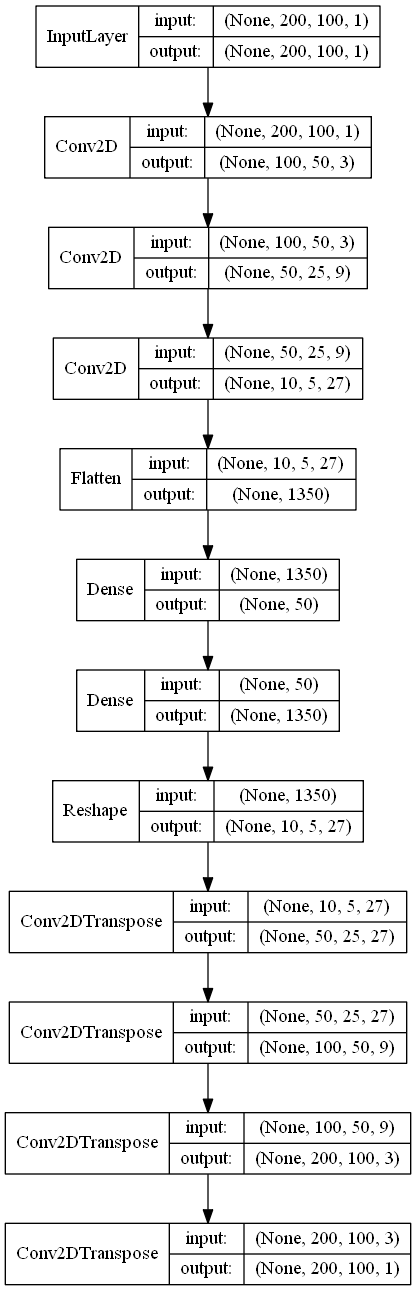

In [5]:
# Load trained model
ae = load_model(path_conv.format("model.h5"))
# Get number of parameters to train
print("Parameters to train: {}".format(ae.count_params()))
# Generate autoencoder architecture graph
plot_model(ae, show_layer_names=False, show_shapes=True, dpi=96)

#### Training process

The loss value for the training and validation dataset evolution is an important indicator whether the model is overfitting or not. Also, it can be used to analyse if the architecture being trained is promising or not. The training evolution is presented below.

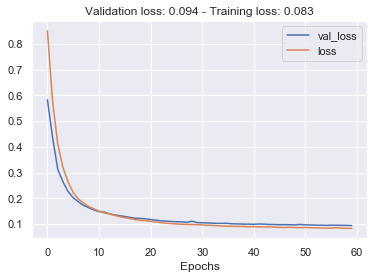

In [6]:
# Load training history
conv_hist = pd.read_hdf(path_conv.format("hist.h5"))

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*conv_hist.min())
conv_hist.plot(grid=True, title=tit)

As we can see, the model does not appear to be overfitting significantly, as the loss values are similar for both datasets. Also, it clear that after the $20^{th}$ epoch the loss value does not decrease significantly and the following epochs the gains were incremental.

Another import values to analyse are the loss value for the test dataset and the global loss obtained. The test dataset was not used to train the neural network and neither to select the model.

In [7]:
# Load the test dataset
x_test = np.load(path_conv.format("test.npy"))

# Evaluate the model against the test dataset
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

# Evaluate the model against all data
var = 2
global_loss = ae.evaluate(dt[:, :, :, [var]] , dt[:, :, :, [var]])
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 1s 8ms/step
Test dataset loss: 0.099
1415/1415 [==============================] - 1s 464us/step
Entire dataset loss: 0.084


As we can see, the test dataset loss was close to the validation dataset, which indicates that the trained model is not suffering significantly from overfitting and has a reasonable generalisation.

Finally, the spatial velocity distribution is presented below, where it is possible to analyse visually if the neural network is performing well or not.

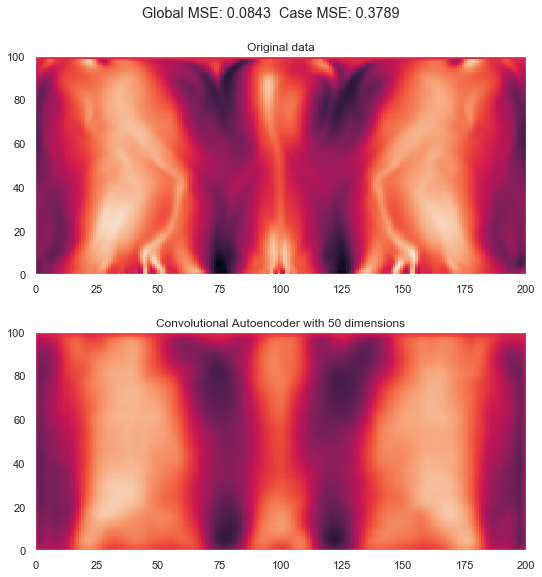

In [8]:
#Comparing the input and output of the autoencoder neural network
idx = 634
# Function to plot the spatial distribution
def plot_func(data_index = 634):
    # Slice the data
    dt_in = dt[data_index, :, :, [var]]
    # Get the neural network output
    dt_out = ae.predict(dt_in[np.newaxis])
    # Plot
    alg = "Convolutional Autoencoder"
    plot_red_comp(dt_in, dt_out[0], 0, 50, global_loss, alg)

# Widget option in case you are running the notebook
widget = False
if widget:
    idx_args = dict(value=634, min=0, max=dt.shape[0], step=1)
    interact(plot_func, data_index=widgets.IntSlider(**idx_args))
else:
    plot_func(idx)

As can be observed in the figure above, it was possible to sucessfully reconstruct the input data using the proposed architecture. However, the best cases are when the data case does not have significant spation variation, for instance the case $1266$ where the MSE was $0.0009$ while for the case $634$ the MSE was $0.3789$. In this last case the reconstruction resembles the inputs but misses small variations.

It is possible to change the cases by using the slider.

### Convolutional autoencoder with dropout

#### Architecture

The main objective of the dropout is to prevent the neural network to overfit, thus it will be evaluated whether is necessary or not in this case. Therefore, a similar neural network to the previously trained convolutional autoencoder was trained, but between each convolutional layer it was placed a dropout layer with probability of $0.2$. A schematic representation of the architecture and the number of parameters trained are presented below:


Parameters to train: 168354


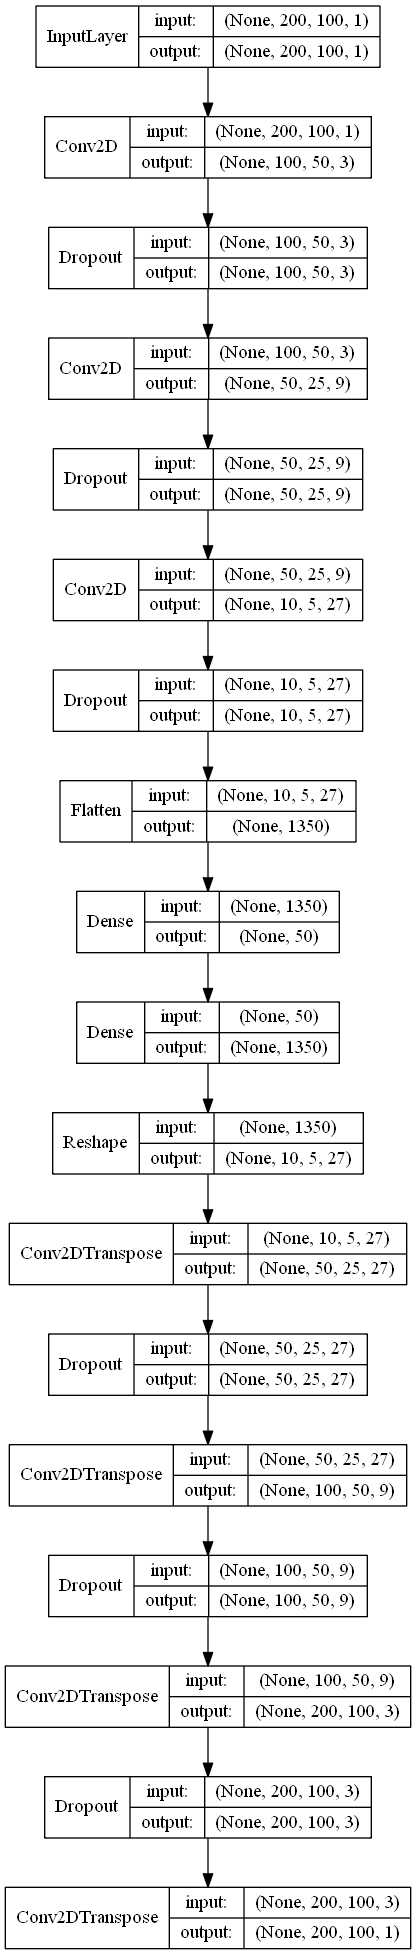

In [9]:
# Load trained model
ae = load_model(path_drop.format("model.h5"))
# Get number of parameters to train
print("Parameters to train: {}".format(ae.count_params()))
# Generate autoencoder architecture graph
plot_model(ae, show_layer_names=False, show_shapes=True, dpi=96)

#### Training process

As previously mentioned, the loss value for the training and validation dataset evolution is an important indicator whether the model is overfitting or not. Also, it is possible to check if the dropout layer prevented the model to overfit or not. The training evolution is presented below.

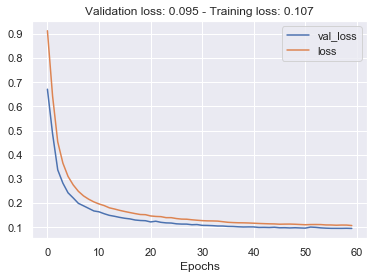

In [10]:
# Load training history
drop_hist = pd.read_hdf(path_drop.format("hist.h5"))

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*drop_hist.min())
drop_hist.plot(grid=True, title=tit)

As we can see, differently from the convolutional layer without drop during all epochs the validation loss was lower than the training loss, which indicates that the dropout prevented the neural network to overfit. However, for both datasets the loss were higher than the neural network without the dropout. The loss evolution along the epochs was similar to the previously shown.

Another import values to analyse are the loss value for the test dataset and the global loss obtained. The test dataset was not used to train the neural network and neither to select the model.

In [11]:
# Load the test dataset
x_test = np.load(path_drop.format("test.npy"))

# Evaluate the model against the test dataset
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

# Evaluate the model against all data
var = 2
global_loss = ae.evaluate(dt[:, :, :, [var]] , dt[:, :, :, [var]])
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 0s 1ms/step
Test dataset loss: 0.109
1415/1415 [==============================] - 1s 409us/step
Entire dataset loss: 0.090


As we can see, the test dataset loss was close to the training dataset, which can indicate that the trained model is not suffering from overfitting and has a reasonable generalisation. Also, the loss for the test dataset was higher than the network without the dropout.

Finally, the spatial velocity distribution is presented below, where it is possible to analyse visually if the neural network is performing well or not.

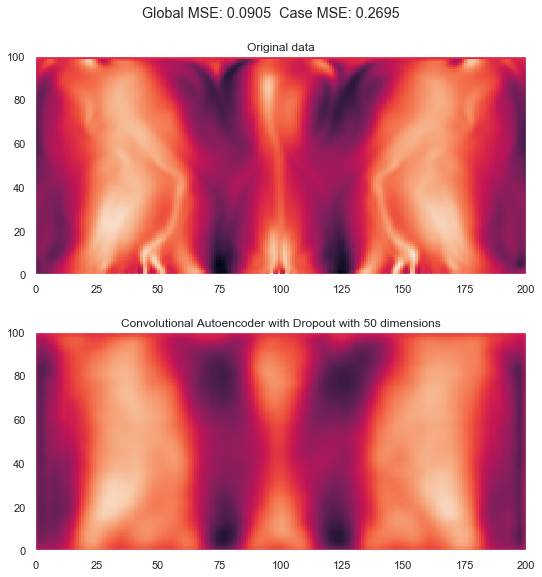

In [12]:
#Comparing the input and output of the autoencoder neural network
idx = 634
# Function to plot the spatial distribution
def plot_func(data_index = 634):
    # Slice the data
    dt_in = dt[data_index, :, :, [var]]
    # Get the neural network output
    dt_out = ae.predict(dt_in[np.newaxis])
    # Plot
    alg = "Convolutional Autoencoder with Dropout"
    plot_red_comp(dt_in, dt_out[0], 0, 50, global_loss, alg)

# Widget option in case you are running the notebook
widget = False
if widget:
    idx_args = dict(value=634, min=0, max=dt.shape[0], step=1)
    interact(plot_func, data_index=widgets.IntSlider(**idx_args))
else:
    plot_func(idx)

Similarly to the neural network without dropout, the best scenarios were when the data case does not have significant spation variation, for instance the case $1266$ where the MSE was $0.0017$ while for the case $634$ the MSE was $0.2695$.

It is possible to change the cases by using the slider.

### VQ-VAE-2 based autoencoder
#### Architecture

The encoder and decoder of convolutional autoencoder architecture trained have $3$ layers. The encoder and decoder have $[3, 9, 27]$ and $[27, 9, 3]$ filters sequentially, respectively. However, as explained in at the [VQ-VAE-2 based autoencoder](./tests/jupyter-notebooks/train_ae_add.ipynb), the VQ-VAE-2 has two bottlenecks, in this case, to keep the same size of dimensionality reduction each have one has a size of $25$. A schematic representation of the architecture and the number of parameters trained are presented below:

Parameters to train: 355876


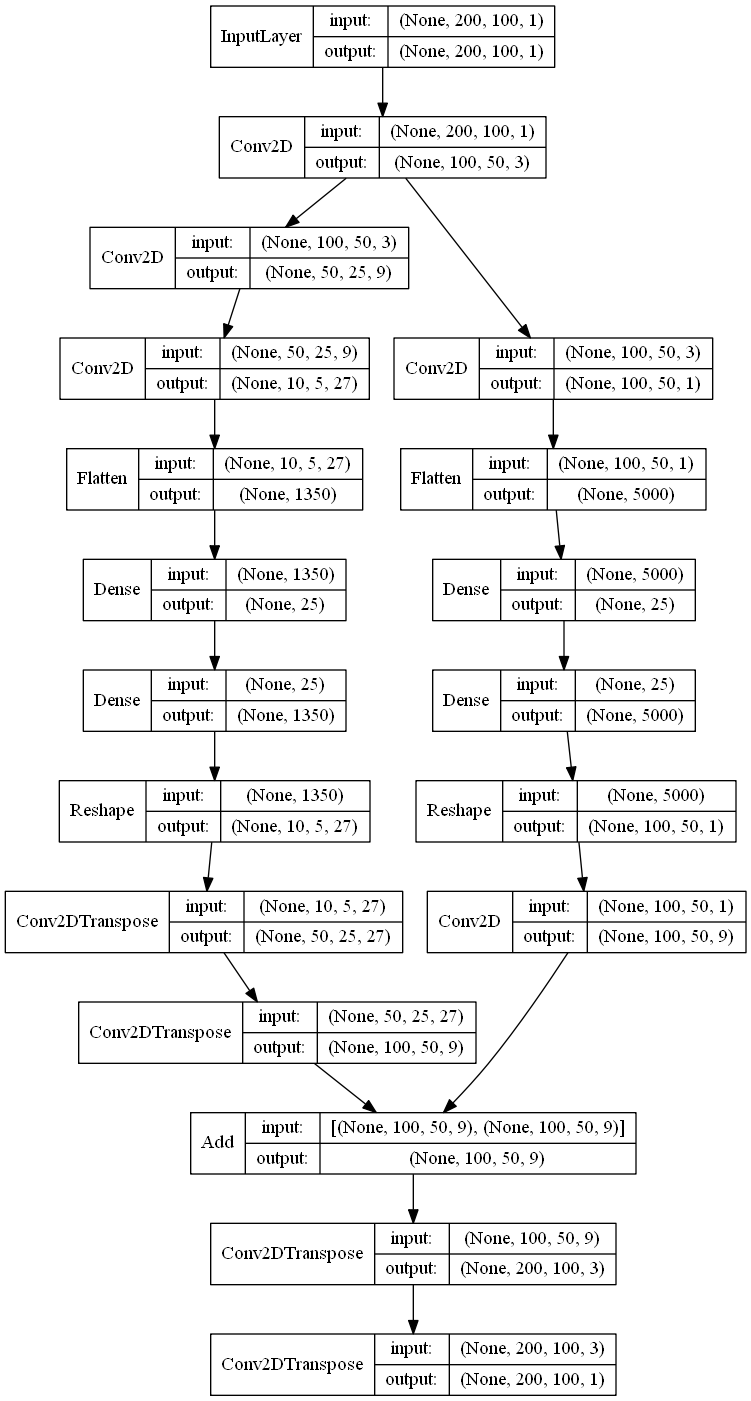

In [13]:
# Load trained model
ae = load_model(path_add.format("model.h5"))
# Get number of parameters to train
print("Parameters to train: {}".format(ae.count_params()))
# Generate autoencoder architecture graph
plot_model(ae, show_layer_names=False, show_shapes=True, dpi=96)

#### Training process

As previously mentioned, the loss value for the training and validation dataset evolution is an important indicator whether the model is overfitting or not. The training evolution is presented below.

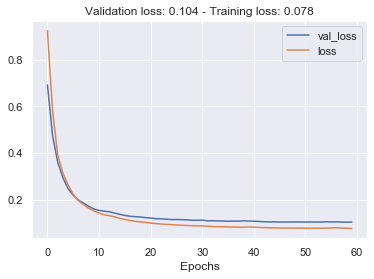

In [14]:
# Load training history
add_hist = pd.read_hdf(path_add.format("hist.h5"))

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*add_hist.min())
add_hist.plot(grid=True, title=tit)

As we can see, similarly to the convolutional autoencoder the model does not appear to be overfitting significantly, as the loss values are similar for both datasets. However, the validation dataset loss is higher than the training dataset. Also, the loss value for both datasets does not change significantly after the $20^{th}$ epoch.

Another import values to analyse are the loss value for the test dataset and the global loss obtained. The test dataset was not used to train the neural network and neither to select the model.

In [15]:
# Load the test dataset
x_test = np.load(path_add.format("test.npy"))

# Evaluate the model against the test dataset
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

# Evaluate the model against all data
var = 2
global_loss = ae.evaluate(dt[:, :, :, [var]] , dt[:, :, :, [var]])
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 0s 1ms/step
Test dataset loss: 0.106
1415/1415 [==============================] - 1s 453us/step
Entire dataset loss: 0.082


As we can see, the test dataset loss was close to the validation dataset, which indicates that the trained model is not suffering significantly from overfitting and has a reasonable generalisation.

Finally, the spatial velocity distribution is presented below, where it is possible to analyse visually if the neural network is performing well or not.

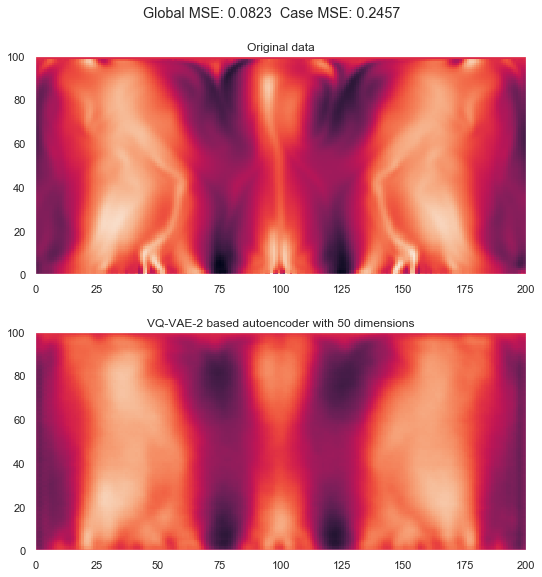

In [16]:
#Comparing the input and output of the autoencoder neural network
idx = 634
# Function to plot the spatial distribution
def plot_func(data_index = 634):
    # Slice the data
    dt_in = dt[data_index, :, :, [var]]
    # Get the neural network output
    dt_out = ae.predict(dt_in[np.newaxis])
    # Plot
    alg = "VQ-VAE-2 based autoencoder"
    plot_red_comp(dt_in, dt_out[0], 0, 50, global_loss, alg)

# Widget option in case you are running the notebook
widget = False
if widget:
    idx_args = dict(value=634, min=0, max=dt.shape[0], step=1)
    interact(plot_func, data_index=widgets.IntSlider(**idx_args))
else:
    plot_func(idx)

Similarly to the previously trained neural networks, the best scenarios were when the data case does not have significant spation variation, for instance the case $1266$ where the MSE was $0.0012$ while for the case $634$ the MSE was $0.2457$.

It is possible to change the cases by using the slider.

### Depthwise convolutional autoencoder
#### Architecture

The encoder and decoder of convolutional autoencoder architecture trained have $3$ layers. The encoder and decoder have $[3, 9, 27]$ and $[27, 9, 3]$ filters sequentially, respectively. However, as explained in at the [ Depthwise Convolutional Autoeconder](./tests/jupyter-notebooks/train_ae_depth.ipynb), the Depthwise Convolutional Autoeconder has different filters for each property, temperature, velocity and pressure. Thus, differently from the previously trained models, in this the neural networks it was used the temperature, pressure and velocity. Also, same as the previous neural network the bottleneck, has a size of $50$. 

A schematic representation of the architecture and the number of parameters trained are presented below:

Parameters to train: 515724


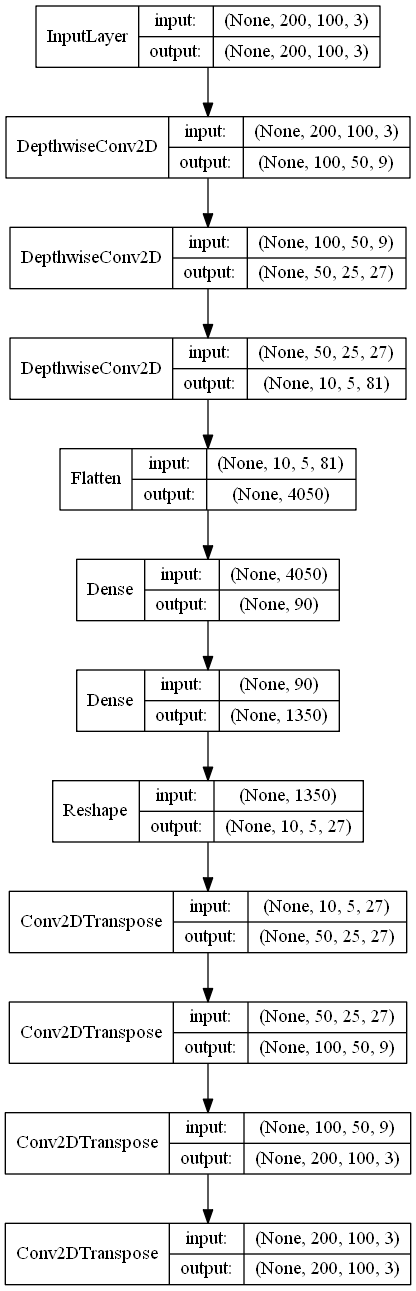

In [17]:
# Load trained model
ae = load_model(path_depth.format("model.h5"))
# Get number of parameters to train
print("Parameters to train: {}".format(ae.count_params()))
# Generate autoencoder architecture graph
plot_model(ae, show_layer_names=False, show_shapes=True, dpi=96)

#### Training process

As previously mentioned, the loss value for the training and validation dataset evolution is an important indicator whether the model is overfitting or not. The training evolution is presented below.

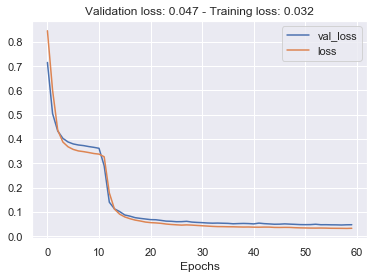

In [18]:
# Load training history
depth_hist = pd.read_hdf(path_depth.format("hist.h5"))

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*depth_hist.min())
depth_hist.plot(grid=True, title=tit)

As we can see, the model does not appear to be overfitting significantly, as the loss values are similar for both datasets. However, the validation dataset loss is higher than the training dataset. It is interesting to note that the loss values for both datasets reach a  plateau between the $5^{th}$ and $10^{th}$ epoch and then decrease significantly after the $12^{th}$ epoch and reach again a plateau where the loss value does not change significantly.

Analysing the trained model against the test dataset was not used to train the neural network and neither to select the model.

In [19]:
# Load the test dataset
x_test = np.load(path_depth.format("test.npy"))

# Test the trained neural network against the test dataset
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

global_loss = ae.evaluate(dt, dt)
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 0s 2ms/step
Test dataset loss: 0.047
1415/1415 [==============================] - 1s 851us/step
Entire dataset loss: 0.035


As we can see, the test dataset loss was close to the validation dataset, which indicates that the trained model is not suffering significantly from overfitting and has a reasonable generalisation.

Finally, the spatial velocity distribution is presented below, where it is possible to analyse visually if the neural network is performing well or not.

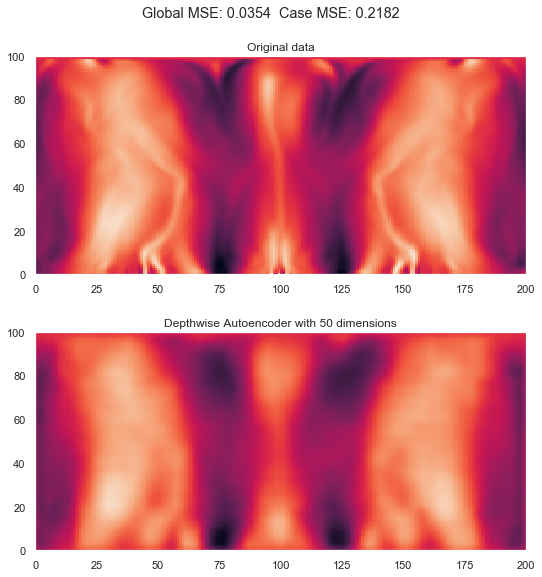

In [20]:
#Comparing the input and output of the autoencoder neural network
idx = 634
var = 2
# Function to plot the spatial distribution
def plot_func(data_index = 634, var=2):
    # Slice the data
    dt_in = dt[data_index]
    # Get the neural network output
    dt_out = ae.predict(dt_in[np.newaxis])
    # Plot
    alg = "Depthwise Autoencoder"
    plot_red_comp(dt_in, dt_out[0], var, 50, global_loss, alg)

# Widget option in case you are running the notebook
widget = False
if widget:
    idx_args = dict(value=634, min=0, max=dt.shape[0], step=1)
    var_args = dict(value=2, min=0, max=2, step=1)
    interact(plot_func, data_index=widgets.IntSlider(**idx_args),
             var=widgets.IntSlider(**var_args))
else:
    plot_func(idx, var=2)

Similarly to the previously trained neural networks, the best scenarios were when the data case does not have significant spation variation, for instance the case $1266$ where the MSE was $0.0029$ while for the case $634$ the MSE was $0.2182$.

It is important to note that the MSE value for the velocity was not considerably different from the other trained neural networks presented before. However, as presented in the training history the loss values were significantly lower than the previously trained models. This difference is related to the MSE values of the pressure spatial distribution that presented low MSE values.

It is possible to change the cases by using the slider and the variable 'var' to change the variable to analyse.

### Summary of results

Finally, the it is presented in the table below the different autoencoder neural networks architectures loss values, in order to select the most promising architectures to perform a hyperparameter optimisation.

|                        | Train loss | Validation loss | Test loss | Dataset loss | Number of parameters |
|------------------------|------------|-----------------|-----------|--------------|----------------------|
| Conv. AE.              | 0.083      | 0.094           | 0.099     | 0.084        | 168354               |
| Conv. with Dropout AE. | 0.107      | 0.095           | 0.109     | 0.09         | 168354               |
| VQ-VAE-2 based AE.     | 0.078      | 0.104           | 0.106     | 0.082        | 355876               |
| Depthwise Conv. AE.    | 0.032      | 0.047           | 0.047     | 0.035        | 515724               |

Also, the table below presents the loss values for every architecture that was shown the loss value and the data reconstructed as images.

|                        | Case 634 | Case 1266 |
|------------------------|----------|-----------|
| Conv. AE.              | 0.3789   | 0.0009    |
| Conv. with Dropout AE. | 0.2695   | 0.0017    |
| VQ-VAE-2 based AE.     | 0.2457   | 0.0012    |
| Depthwise Conv. AE.    | 0.2182   | 0.0029    |

The results points to the VQ-VAE-2 based auto encoder and the regularised autoencoder with dropout. The depthwise convolutional autoencoder did not presented a significant increase in peformance despite the significant increase in number of parameters to train.

Thus, the hyperparameter optimisation will be conducted with a Convolutional autoencoder regularised and the VQ-VAE-2 based autoencoder.